In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import pandas as pd
import tensorflow as tf
import numpy as np
import cv2

In [2]:
# Chemin vers les images
image_dir = "raw_data/train/images"

#Chemin vers les labels
label_dir = "raw_data/train/labels"

# Lister les images
image_files = sorted(os.listdir(image_dir))


In [3]:
# Sélectionne la première image
image_path = os.path.join(image_dir, image_files[0])

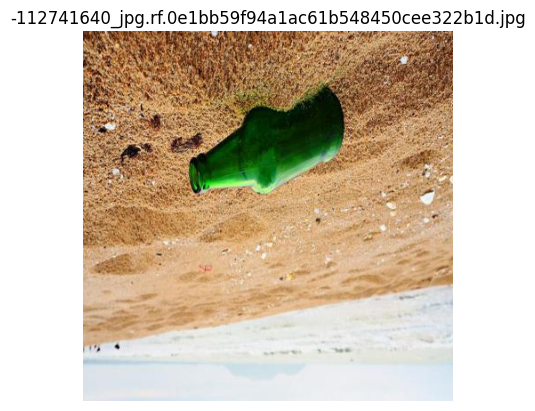

In [4]:
# Charge et affiche l'image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(image_files[0])
plt.show()


In [5]:
# Nom du label
label_filename = os.path.splitext(image_files[0])[0] + ".txt"

In [6]:
#Relier la première image au premier label
#Pas sûr d'utiliser la bonne fonction, est ce que je créer un path pour les deux ou est ce que je les relie entre eux ?
image_path = os.path.join(image_dir, image_files[0])
image_path

'raw_data/train/images/-112741640_jpg.rf.0e1bb59f94a1ac61b548450cee322b1d.jpg'

In [7]:
#Avoir le chemin du premier label lier à celui de la première image
label_path = os.path.join(label_dir, label_filename)
label_path

'raw_data/train/labels/-112741640_jpg.rf.0e1bb59f94a1ac61b548450cee322b1d.txt'

In [8]:
#Ouvrir fichier texte et voir le nombre de ligne
#Ou alors faire un CSV par nombre de ligne comme ça j'ai un CSV avec tout les fichiers ou il y a 1, 2 et 3 lignes
#Itérer sur  les labels pour voir directement le nombre de ligne, et après faire les CSV

#Pouvoir choisir le nombre d'objets par image - pour pas refaire milles fois les images ou y'a qu'un image

#Regarde si data set from directory il n'y a pas mieux vu que j'ai le label dans un dossier différent

#tf.image.pad_to_bounding_box - pour le padding

#Avoir la raw_data sur un bucket partagé

#Faire que la taille (64,64) soit un paramètre pour pouvoir être changer à tout moment

# Fonction pour choisir le nombre d'objets sur l'image 


In [9]:
#Create a DataFrame

df = pd.read_csv('raw_data/ocean_waste_csv/train_annotations.csv')
df["filename"].value_counts()

Image_127_jpg.rf.29df55a967c0e895508b2b7e232b7b07.jpg                 299
Image_127_jpg.rf.f463c01218018fa089e819232e221dfa.jpg                 299
Image_127_jpg.rf.65b0c2a562a13246ff7734703f219ec5.jpg                 299
Image_127_jpg.rf.2b4a16ddea9cd268cc2bf90be2730884.jpg                 299
Image_127_jpg.rf.44ec8c1ade1fd79ad7c944f21ac59161.jpg                 298
                                                                     ... 
20200304_164740_jpg.rf.8197a42e797ec64d8ad23eacb9ef14f7.jpg             1
uwg_g-1125__fliph_jpeg_jpg.rf.81d602aad77dade89cbd276651491c71.jpg      1
slp03_jpg.rf.81d5a7a48c8ec1da6895655577a08b0d.jpg                       1
bottle-on-beach-1-1_jpg.rf.81e83cb00eeebc27352996dcfa54214e.jpg         1
pet-20bottle-20-55-_jpg.rf.c9ebd4728406d79d3966c6c02812c467.jpg         1
Name: filename, Length: 20868, dtype: int64

In [10]:
#Filtrer les images selon le nombres d'objets

def filter_images(csv_path, min_objects=1, max_objects=None):
#csv_path = chemin vers le csv --> str
#min_objects = nombre minimum d'objets à garder --> int
#max_object = nomber maximum d'objets à garder --> int

    df = pd.read_csv(csv_path)

    #Compter le nombre d'occurence des noms des images
    count = df["filename"].value_counts()

    # Filtrer selon les bornes min/max
    if max_objects is not None:
        valid_filenames = count[(count >= min_objects) & (count <= max_objects)].index
    else:
        valid_filenames = count[count >= min_objects].index

    # Garder uniquement les lignes correspondantes
    filtered_df = df[df['filename'].isin(valid_filenames)]

    return filtered_df


In [11]:
#Exemple avec mon csv_path
csv_path = 'raw_data/ocean_waste_csv/train_annotations.csv'
filter_images(csv_path = csv_path, max_objects= 1)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,sld68_jpg.rf.0017b135aba2937de3126e1dc0c9b4c8.jpg,1256,732,Plastic,362,175,469,281
27,abandoned-bottle-near-sea-beer-beach-should-be...,800,533,Glass,217,282,720,479
28,0285_jpg.rf.0007aacc96977b4bde4c44ec921ae270.jpg,1920,1080,Plastic,532,602,597,680
35,51_PNG.rf.001a69fcd912c43b773c458651df8887.jpg,1601,900,Plastic,623,290,715,498
38,sld10_jpg.rf.0024aef4dde70cfbc3340e27d4975cf5.jpg,1538,1158,Plastic,883,879,1053,1008
...,...,...,...,...,...,...,...,...
111646,slp15_jpg.rf.c9dd5c347a24ffc3210950f6370df5f8.jpg,1193,740,Plastic,493,131,595,169
111647,2e1chat_jpg.rf.c9e62322d095c5f7cf9c0c2a04e02a3...,640,413,Metal,218,154,449,272
111648,sld56_jpg.rf.c9db48c28ed4c553046dce82178962c9.jpg,753,575,Plastic,113,374,265,539
111660,Image_474_jpg.rf.c9cab0f6563103e8ee0c49d21db09...,416,416,Plastic,219,239,416,367


# Preprocessing 

In [12]:
#Redimensionner les images avec du padding si nécessaire
def resize_with_padding(image_path, target_size=(64, 64)):

    #print(image_path)

    #On lis le contenu du path
    image_file = tf.io.read_file(image_path)

    #print(image_file)

    #On transforme ce qu'on lit en image
    image = tf.image.decode_jpeg(image_file, channels=3)

    #print(image)

    #Ca marche pas avec des floats au dessus de 1
    image = tf.image.convert_image_dtype(image, tf.float32)

    #tf.shape - Returns a tensor containing the shape of the input tensor.
    image_shape = tf.shape(image)

    #print(image_shape)

    #Trouver hauteur et largeur de l'image
    height = image_shape[0]
    width = image_shape[1]

    #Trouver la taille de la plus grande dimension, pour que ce soit la taille du carré que l'on va utiliser pour le padding
    max_dim = tf.maximum(height, width)

    #On calcule combien de pixels ajouter en haut/bas et à gauche/droite, pour que l’image devienne carrée, centrée dans le carré.
    #On divise par deux puisque il y a ura la moitié au dessus et la moitié en dessous
    pad_height = (max_dim - height) // 2
    pad_width = (max_dim - width) // 2

    #On positionne l'image dans un cadre plus grand
    #On met un certain nombre de pixels en haut/bas ou droite/gauche, dépendant de ce qu'on a calculer avant
    padded_image = tf.image.pad_to_bounding_box(
        image, pad_height, pad_width, max_dim, max_dim
    )

    #On redimensionne la taille finale
    final_image = tf.image.resize(padded_image, target_size)

    # plt.imshow(final_image)
    # plt.axis('off')
    # plt.show()

    return final_image


In [13]:
img_resized = resize_with_padding("raw_data/ocean waste.v2i.tensorflow/train/sld68_jpg.rf.0017b135aba2937de3126e1dc0c9b4c8.jpg")

type(img_resized)

tensorflow.python.framework.ops.EagerTensor

# Resize les bounding boxes


In [14]:
#Resize les bounding boxes comme j'ai resize les images

def resize_bounding_boxes(df, target_size = (64,64)):
    #Prend comme argument le dataframe avec toutes les infos du csv et la target_size
    #Redonne un dataframe avec les datas mise à jour par rapport à la target_size

    new_bounding_boxes = []
    #Liste ou il y a aura les bounding boxes de bonnes taille

    for index, row in df.iterrows():
    # mais on n’utilise pas index je crois

        width, height = row['width'], row['height']
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

        max_dim = max(width, height) #Taille du carré qu'on va obtenir après le padding
        pad_height = (max_dim - height) // 2 #Combien de pixels on ajoute
        pad_width = (max_dim - width) // 2

        #On décale les x/y selon les nouvelles dimensions
        xmin_padded = xmin + pad_width
        xmax_padded = xmax + pad_width
        ymin_padded = ymin + pad_height
        ymax_padded = ymax + pad_height


        #Calculer le facteur d’échelle entre la taille de l’image paddée  et la taille finale souhaitée
        #Comme ça on sait de combien on augmente ou diminue chaque pixel
        scale = target_size[0] / max_dim

        #On applique le scale aux données paddées
        xmin_resized = xmin_padded * scale
        xmax_resized = xmax_padded * scale
        ymin_resized = ymin_padded * scale
        ymax_resized = ymax_padded * scale

        #On enregistre les résultats de cette ligne sous forme de dictionnaire, qu’on ajoute à la liste new_boxes.
        new_bounding_boxes.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': xmin_resized,
            'ymin': ymin_resized,
            'xmax': xmax_resized,
            'ymax': ymax_resized
        })

    df_bounding_boxes = pd.DataFrame(new_bounding_boxes)

    return df_bounding_boxes

In [15]:
df = pd.read_csv('raw_data/ocean_waste_csv/train_annotations.csv')

df_test = df.head(5)

df_test_resize = resize_bounding_boxes(df_test)

df_test_resize

,filename,width,height,class,xmin,ymin,xmax,ymax
0,sld68_jpg.rf.0017b135aba2937de3126e1dc0c9b4c8.jpg,64,64,Plastic,18.445860,22.267516,23.898089,27.668790
1,image392_jpg.rf.000274dacb5c614b9c4838233565f2...,64,64,Plastic,33.828571,0.152381,58.666667,25.600000
2,image392_jpg.rf.000274dacb5c614b9c4838233565f2...,64,64,Plastic,41.295238,43.885714,51.200000,62.171429
3,image392_jpg.rf.000274dacb5c614b9c4838233565f2...,64,64,Plastic,9.142857,55.619048,16.304762,62.780952
4,image392_jpg.rf.000274dacb5c614b9c4838233565f2...,64,64,Plastic,4.266667,42.209524,19.809524,53.180952


# Tout mettre en commun

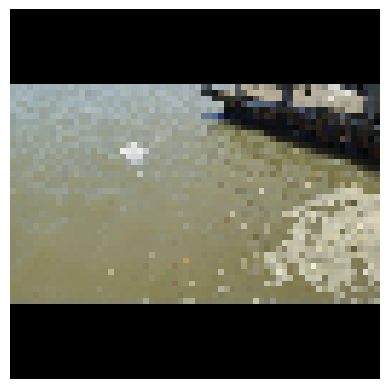

In [16]:
plt.imshow(img_resized)
plt.axis('off')
plt.show()

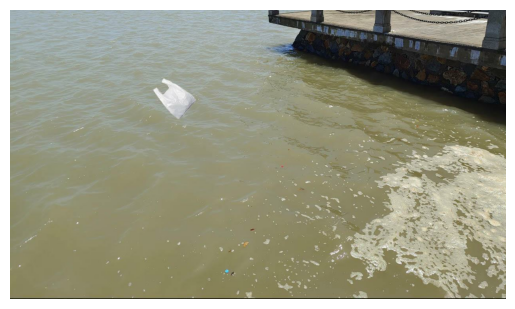

In [17]:
 #On lis le contenu du path
image_file_test = tf.io.read_file("raw_data/ocean waste.v2i.tensorflow/train/sld68_jpg.rf.0017b135aba2937de3126e1dc0c9b4c8.jpg")

#print(image_file)

#On transforme ce qu'on lit en image
image_test = tf.image.decode_jpeg(image_file_test, channels=3)

#print(image)

#Ca marche pas avec des floats au dessus de 1
image_test = tf.image.convert_image_dtype(image_test, tf.float32)

plt.imshow(image_test)
plt.axis('off')
plt.show()

# Save les datas au niveau local 


In [18]:

from PIL import Image, ImageDraw

In [33]:
def preprocess_and_save_dataset(
    csv_path,
    image_folder,
    preprocessed_images_root,
    target_size=(64, 64),
    gcp=False
):
    ''' csv_path (str) : chemin vers le fichier d’annotations

    image_folder (str) : dossier contenant les images originales

    preprocessed_images (str) : racine du dossier de sortie

    target_size (tuple) : dimension finale (par défaut (64, 64))

    gcp (bool) : pour uploader vers GCS '''

    df = pd.read_csv(csv_path)


    # ten= df["filename"].unique()[:10]

    # df_test = df[df["filename"].isin(ten)]

    df_resized = resize_bounding_boxes(df, target_size)

    size_file = str(target_size[0])
    split_name = os.path.basename(image_folder.rstrip("/"))
    output_dir = os.path.join(preprocessed_images_root, f"preprocessed_images_{size_file}_{split_name}")
    os.makedirs(output_dir, exist_ok=True)

    # Boucler sur chaque image unique dans le CSV
    for filename in df_resized['filename'].unique():
        #Construction du chemin complet vers l'image
        image_path = os.path.join(image_folder, filename)

        try:
            # Redimensionner et ajouter du padding à l'image
            image_tensor = resize_with_padding(image_path, target_size)

            # 1. Convertir le tf en np car PIL.Image ne prend que des arrays
            # 2. Faire *255 car on avait mis au format 0 à 1 pour des questions de stabilités, mais que pour sortir des images il faut des couleurs
            # 3. On remet en int car les floats ne sont pas acceptés par PIL
            image_array = (image_tensor.numpy() * 255).astype(np.uint8)

            # Définir le chemin de sortie
            output_path = os.path.join(output_dir, filename)

            if gcp:
                # Je sais pas comment envoyer sur le cloud
                print(f"Image prête pour upload : {filename}")
            else:
                # Sauvegarde locale
                # Image.fromarray transforme l'array en image
                #.save() permet de le save dans le format que je veux en suivant le chemin que je veux
                Image.fromarray(image_array).save(output_path, format="JPEG")

        except Exception as e:
            print(f"Erreur avec {filename} : {e}")

        # Sauvegarder le CSV des bboxes redimensionnées car elles ont changé de coordonnées
    if gcp:
        print("CSV prêt pour upload")
    else:
        csv_output_path = os.path.join(output_dir, f"resized_annotations_{size_file}_{split_name}.csv")
        df_resized.to_csv(csv_output_path, index=False)

    return None

# Afficher les bounding boxes

In [ ]:
# Fonction pour afficher les bounding boxes
def display_bounding_boxes(df_resized, image_folder, filename, show = True, color = 'red', width = 2):
    '''df_resized (pd.DataFrame): le DataFrame contenant les bboxes redimensionnées
        image_folder (str): le dossier contenant les images redimensionnées
        filename (str): le nom de l'image à afficher
        show (bool): si True, affiche l'image avec bboxes
        color (str): couleur des rectangles
        width (int): épaisseur des lignes de bounding box
    '''

    image_path = os.path.join(image_folder, filename)
     # Charger l'image
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f" Image introuvable : {image_path}")
        return

    # Récupérer les bounding boxes correspondantes
    df_img = df_resized[df_resized["filename"] == filename]

    # Dessiner les rectangles avec PIL
    draw = ImageDraw.Draw(image)
    for index, row in df_img.iterrows():
        box = [row["xmin"], row["ymin"], row["xmax"], row["ymax"]]
        draw.rectangle(box, outline=color, width=width)

    if show:
        image.show()

    return image

In [35]:
preprocess_and_save_dataset(
    csv_path="raw_data/ocean_waste_csv/train_annotations.csv",
    image_folder="raw_data/ocean waste.v2i.tensorflow/train",
    preprocessed_images_root="raw_data",
    target_size=(64, 64),
    gcp=False
)


In [22]:
data_test_annotations_roboflow = pd.read_csv('raw_data/ocean_waste_csv/train_annotations.csv')
data_test_annotations_roboflow

,filename,width,height,class,xmin,ymin,xmax,ymax
0,sld68_jpg.rf.0017b135aba2937de3126e1dc0c9b4c8.jpg,1256,732,Plastic,362,175,469,281
1,image392_jpg.rf.000274dacb5c614b9c4838233565f2...,420,420,Plastic,222,1,385,168
2,image392_jpg.rf.000274dacb5c614b9c4838233565f2...,420,420,Plastic,271,288,336,408
3,image392_jpg.rf.000274dacb5c614b9c4838233565f2...,420,420,Plastic,60,365,107,412
4,image392_jpg.rf.000274dacb5c614b9c4838233565f2...,420,420,Plastic,28,277,130,349
...,...,...,...,...,...,...,...,...
111657,Image_148_jpg.rf.c9de461569ec5183e805022842c2a...,416,416,Plastic,22,310,52,350
111658,Image_148_jpg.rf.c9de461569ec5183e805022842c2a...,416,416,Plastic,90,175,114,192
111659,Image_148_jpg.rf.c9de461569ec5183e805022842c2a...,416,416,Plastic,205,245,223,274
111660,Image_474_jpg.rf.c9cab0f6563103e8ee0c49d21db09...,416,416,Plastic,219,239,416,367


In [23]:
data_test_annotations = pd.read_csv('raw_data/preprocessed_images_64/resized_annotations_64.csv')
data_test_annotations

,filename,width,height,class,xmin,ymin,xmax,ymax
0,sld68_jpg.rf.0017b135aba2937de3126e1dc0c9b4c8.jpg,64,64,Plastic,18.445860,22.267516,23.898089,27.668790
1,image392_jpg.rf.000274dacb5c614b9c4838233565f2...,64,64,Plastic,33.828571,0.152381,58.666667,25.600000
2,image392_jpg.rf.000274dacb5c614b9c4838233565f2...,64,64,Plastic,41.295238,43.885714,51.200000,62.171429
3,image392_jpg.rf.000274dacb5c614b9c4838233565f2...,64,64,Plastic,9.142857,55.619048,16.304762,62.780952
4,image392_jpg.rf.000274dacb5c614b9c4838233565f2...,64,64,Plastic,4.266667,42.209524,19.809524,53.180952
...,...,...,...,...,...,...,...,...
111657,Image_148_jpg.rf.c9de461569ec5183e805022842c2a...,64,64,Plastic,3.384615,47.692308,8.000000,53.846154
111658,Image_148_jpg.rf.c9de461569ec5183e805022842c2a...,64,64,Plastic,13.846154,26.923077,17.538462,29.538462
111659,Image_148_jpg.rf.c9de461569ec5183e805022842c2a...,64,64,Plastic,31.538462,37.692308,34.307692,42.153846
111660,Image_474_jpg.rf.c9cab0f6563103e8ee0c49d21db09...,64,64,Plastic,33.692308,36.769231,64.000000,56.461538


In [24]:
df_resized = pd.read_csv("raw_data/preprocessed_images/resized_annotations.csv")

In [25]:
for filename in df_resized["filename"].unique():
    display_bounding_boxes(
        df_resized=df_resized,
        image_folder="raw_data/preprocessed_images",
        filename=filename
    )

# Partie à ajouter à main pour appeller ma fonction 

In [26]:
# from ml_logic.preprocessor import preprocess_and_save_dataset

# if __name__ == "__main__":
#     preprocess_and_save_dataset(
#         csv_path="raw_data/ocean_waste_csv/train_annotations.csv",
#         image_folder="raw_data/ocean_waste_images",
#         output_folder="raw_data/processed_images",  # ✅ ici on enregistre
#         target_size=(64, 64),
#         cloud_mode=False
#     )
